<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Time series: exchange rates

In this exercise we'll use the exchange rates dataset we saw before. In a previous exercise we did some cleaning of the data, so you can use your previously cleaned version, or the one provided here.

For this exercise we'll focus on just the GBP - USD exchange rate, which you can extract from the relevant column in the data (or use the data provided).

### 1. Load the data

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("../../data/exchange_rates_usd_gbp.csv")
df.head()

,date,rate_USD_per_GBP
0,1971-01-04,2.3938
1,1971-01-05,2.3949
2,1971-01-06,2.3967
3,1971-01-07,2.3963
4,1971-01-08,2.3972


### 2. Convert the date column to be a date type

In [3]:
df["date"] = pd.to_datetime(df["date"])


In [4]:
df.head().dtypes

date                datetime64[ns]
rate_USD_per_GBP            object
dtype: object

### 3. Check the data types - is the rate field numeric like you'd expect?

As in the previous exercise, you may notice the rate column is an "object" type, not a number (but also not `NaN`). This indicates some of the values are invalid, i.e. strings.

Find these, and set them explicitly to be nulls, then convert the column to a numeric type.

In [5]:
df.head()

,date,rate_USD_per_GBP
0,1971-01-04,2.3938
1,1971-01-05,2.3949
2,1971-01-06,2.3967
3,1971-01-07,2.3963
4,1971-01-08,2.3972


In [6]:
import numpy as np

df["is_ND"] = df["rate_USD_per_GBP"] == "ND"
df.head()

,date,rate_USD_per_GBP,is_ND
0,1971-01-04,2.3938,False
1,1971-01-05,2.3949,False
2,1971-01-06,2.3967,False
3,1971-01-07,2.3963,False
4,1971-01-08,2.3972,False


In [7]:
# take a look at some examples
df[df['is_ND']==True].head(3)

,date,rate_USD_per_GBP,is_ND
29,1971-02-12,ND,True
30,1971-02-15,ND,True
105,1971-05-31,ND,True


In [8]:
df.loc[df["is_ND"], "rate_USD_per_GBP"] = np.nan
df[df['is_ND']==True].head(3)

,date,rate_USD_per_GBP,is_ND
29,1971-02-12,NaN,True
30,1971-02-15,NaN,True
105,1971-05-31,NaN,True


In [9]:
df.isnull().sum()

date                  0
rate_USD_per_GBP    461
is_ND                 0
dtype: int64

In [10]:
df["rate_USD_per_GBP"] = df["rate_USD_per_GBP"].astype(float)
df.isnull().sum()

date                  0
rate_USD_per_GBP    461
is_ND                 0
dtype: int64

In [11]:
df["is_ND"].value_counts()

False    11709
True       461
Name: is_ND, dtype: int64

### 4. Dig into the missing values.

- What dates/periods do they correspond to?
- What % of rows are missing a rate?
- Are there prolonged periods of missingness, or are missing days seemingly randomly scattered?

In [12]:
df.loc[df["is_ND"], "date"].dt.year.value_counts().sort_index().tail()

2013    10
2014    11
2015    10
2016    10
2017     6
Name: date, dtype: int64

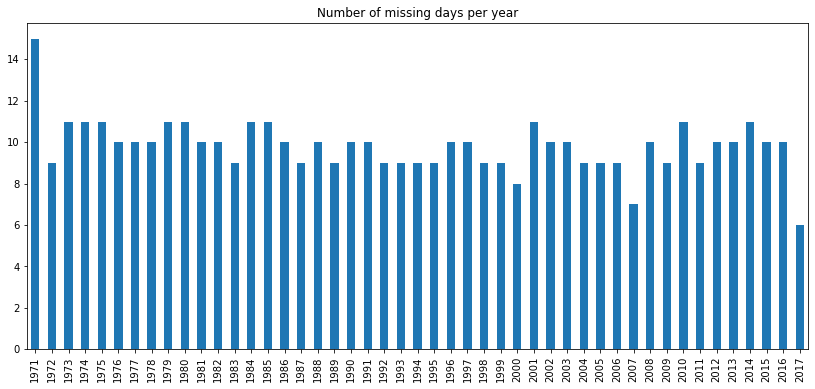

In [13]:
# examine missing values per year
fig, ax = plt.subplots(figsize=(14, 6))

df.loc[df["is_ND"], "date"].dt.year.value_counts().sort_index().plot.bar(ax=ax)

ax.set_title("Number of missing days per year")

plt.show()

So roughly 10 missing days per year. Is there a pattern?

In [14]:
df['month']=df["date"].dt.month
df.head(2)

,date,rate_USD_per_GBP,is_ND,month
0,1971-01-04,2.3938,False,1
1,1971-01-05,2.3949,False,1


In [15]:
df.loc[df["is_ND"], "date"].dt.month.value_counts().sort_index()

1     73
2     59
5     47
7     43
8      5
9     46
10    48
11    97
12    43
Name: date, dtype: int64

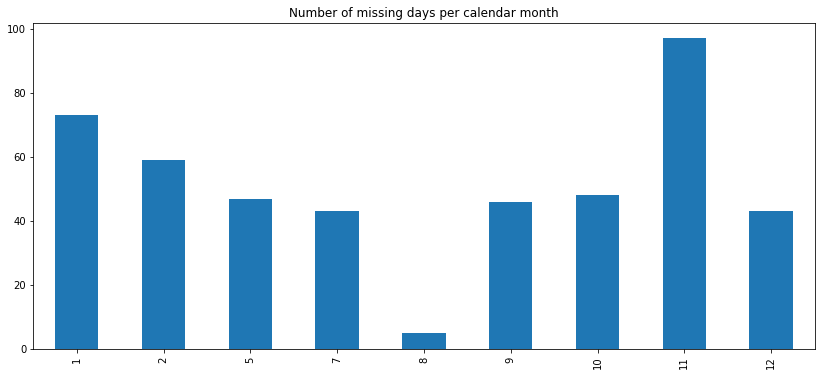

In [16]:
# examine missing values per year
fig, ax = plt.subplots(figsize=(14, 6))

df.loc[df["is_ND"], "date"].dt.month.value_counts().sort_index().plot.bar(ax=ax)

ax.set_title("Number of missing days per calendar month")

plt.show()

Seems to be scattered across multiple months, no clear pattern

In [17]:
df["is_ND"].value_counts(normalize=True)

False    0.96212
True     0.03788
Name: is_ND, dtype: float64

Only under 4% missing, not terrible

### 5. Deal with the missing values

There are several options when filling missing values in time series. We can:

- use the previous value until the next non-value
- use the next valid observation (almost the opposite of the previous method)
- interpolate between missing values

Try these methods using pandas! Here are some relevant links:

- [`fillna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)
- [`interpolate`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate)

In [18]:
# one option: "forward fill" previous observation
df["rate_imputed"] = df["rate_USD_per_GBP"].fillna(method="ffill")

# examine one instance of the rate being imputed
df.iloc[12128:12135]

,date,rate_USD_per_GBP,is_ND,month,rate_imputed
12128,2017-06-29,1.2984,False,6,1.2984
12129,2017-06-30,1.2995,False,6,1.2995
12130,2017-07-03,1.2951,False,7,1.2951
12131,2017-07-04,NaN,True,7,1.2951
12132,2017-07-05,1.2934,False,7,1.2934
12133,2017-07-06,1.2967,False,7,1.2967
12134,2017-07-07,1.2880,False,7,1.2880


In [19]:
# other, more sophisticated option: interpolate between valid observations
# many methods are available, let's just keep it simple and interpolate linearly for now
df["rate_imputed"] = df["rate_USD_per_GBP"].interpolate()

# examine one instance of the rate being imputed
df.iloc[12128:12135]

,date,rate_USD_per_GBP,is_ND,month,rate_imputed
12128,2017-06-29,1.2984,False,6,1.29840
12129,2017-06-30,1.2995,False,6,1.29950
12130,2017-07-03,1.2951,False,7,1.29510
12131,2017-07-04,NaN,True,7,1.29425
12132,2017-07-05,1.2934,False,7,1.29340
12133,2017-07-06,1.2967,False,7,1.29670
12134,2017-07-07,1.2880,False,7,1.28800


Verify we have no NULLs

In [20]:
df["rate_imputed"].isnull().sum()

0

### 6. Now plot the time series with the imputed values

What can you say about this series at first glance?

In [21]:
df.head()

,date,rate_USD_per_GBP,is_ND,month,rate_imputed
0,1971-01-04,2.3938,False,1,2.3938
1,1971-01-05,2.3949,False,1,2.3949
2,1971-01-06,2.3967,False,1,2.3967
3,1971-01-07,2.3963,False,1,2.3963
4,1971-01-08,2.3972,False,1,2.3972


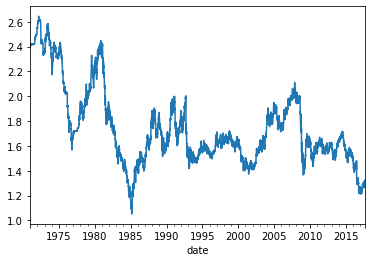

In [22]:
import matplotlib.pyplot as plt

df.set_index("date")["rate_imputed"].plot();

Definitely non-stationary, values seem to change more dramatically over years, not as granularly as daily

### 7. Play around with the `resample` method to view the time series at different granularities

In [23]:
df = df.set_index("date")
df.head()

,rate_USD_per_GBP,is_ND,month,rate_imputed
date,,,,
1971-01-04,2.3938,False,1,2.3938
1971-01-05,2.3949,False,1,2.3949
1971-01-06,2.3967,False,1,2.3967
1971-01-07,2.3963,False,1,2.3963
1971-01-08,2.3972,False,1,2.3972


In [24]:
df.groupby('month')["rate_imputed"].mean()

month
1     1.754012
2     1.750349
3     1.740983
4     1.747516
5     1.750168
6     1.743791
7     1.746809
8     1.741871
9     1.741490
10    1.741616
11    1.738639
12    1.739455
Name: rate_imputed, dtype: float64

In [25]:
# monthly
df.resample("M")["rate_imputed"].mean()

date
1971-01-31    2.405750
1971-02-28    2.417730
1971-03-31    2.418696
1971-04-30    2.417868
1971-05-31    2.418633
                ...   
2017-04-30    1.263925
2017-05-31    1.292446
2017-06-30    1.281032
2017-07-31    1.299379
2017-08-31    1.295816
Freq: M, Name: rate_imputed, Length: 560, dtype: float64

In [26]:
# monthly
df.resample("MS")["rate_imputed"].mean().head()

date
1971-01-01    2.405750
1971-02-01    2.417730
1971-03-01    2.418696
1971-04-01    2.417868
1971-05-01    2.418633
Freq: MS, Name: rate_imputed, dtype: float64

In [27]:
# monthly
df.resample("A")["rate_imputed"].mean().head()

date
1971-12-31    2.444646
1972-12-31    2.501216
1973-12-31    2.451542
1974-12-31    2.339790
1975-12-31    2.219913
Freq: A-DEC, Name: rate_imputed, dtype: float64

<AxesSubplot:xlabel='date'>

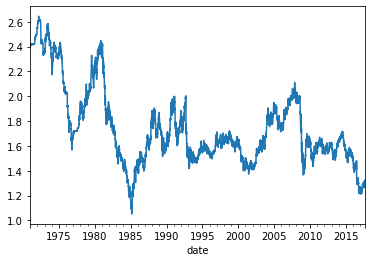

In [28]:
df['rate_imputed'].plot()

<AxesSubplot:xlabel='date'>

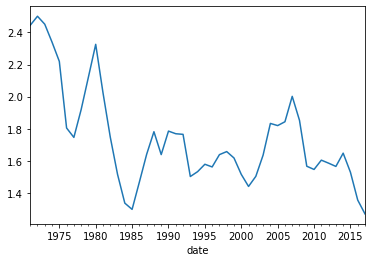

In [29]:
# annual
df.resample("YS")["rate_imputed"].mean().plot()

### 8. Smooth the time series by plotting it as a 6-month rolling average

In [30]:
df["rate_imputed"].rolling(window=3, center=False)

Rolling [window=3,center=False,axis=0,method=single]

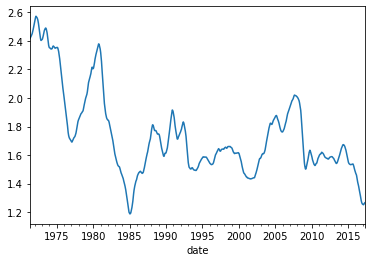

In [31]:
df["rate_imputed"].rolling(window=180, center=True).mean().dropna().plot();

### 9. Plot the autocorrelation and partial autocorrelation. What do you conclude?

Do this for the raw time series, and one with monthly averages instead of daily values.

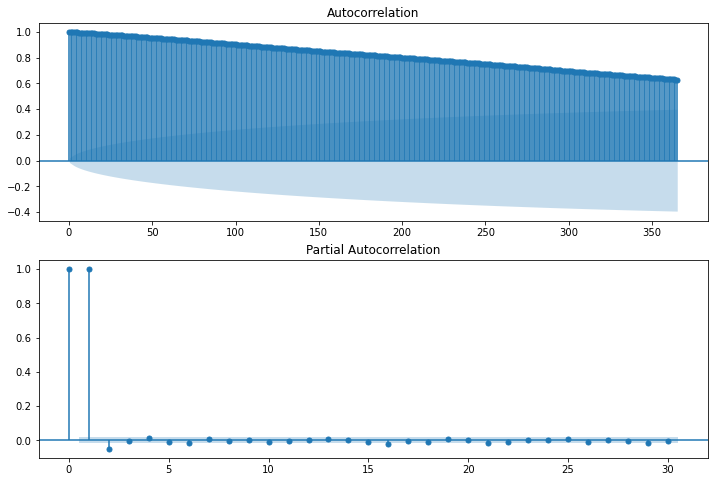

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(df["rate_imputed"], lags=365, ax=ax[0])
plot_pacf(df["rate_imputed"], lags=30, ax=ax[1])

plt.show()

The autocorrelation is very high for previous days, but once you account for the effect of all other days it seems the time series is hard to forecast beyond a single day!

In [33]:

monthly = df.resample("MS")["rate_imputed"].mean()

monthly

date
1971-01-01    2.405750
1971-02-01    2.417730
1971-03-01    2.418696
1971-04-01    2.417868
1971-05-01    2.418633
                ...   
2017-04-01    1.263925
2017-05-01    1.292446
2017-06-01    1.281032
2017-07-01    1.299379
2017-08-01    1.295816
Freq: MS, Name: rate_imputed, Length: 560, dtype: float64

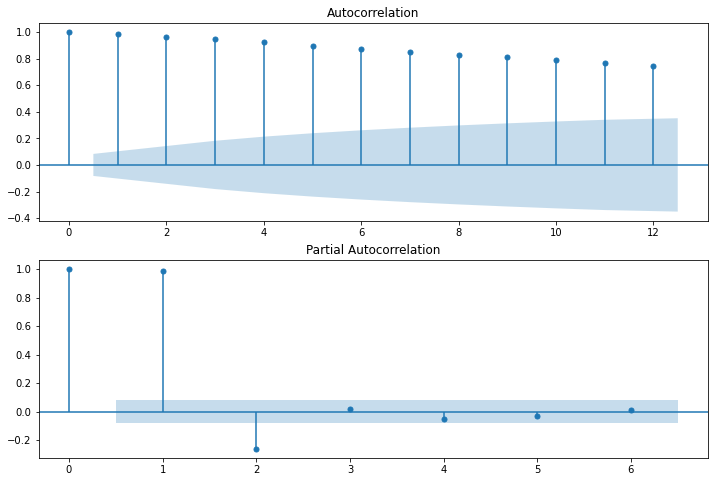

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(monthly, lags=12, ax=ax[0])
plot_pacf(monthly, lags=6, ax=ax[1])

plt.show()

Same as the daily one, once you go beyond one month, it's not strongly correlated with itself

### 10. Create a decomposition plot for the monthly time series. What do you see?

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(monthly, period=12)


In [36]:
decomposition.resid

date
1971-01-01   NaN
1971-02-01   NaN
1971-03-01   NaN
1971-04-01   NaN
1971-05-01   NaN
              ..
2017-04-01   NaN
2017-05-01   NaN
2017-06-01   NaN
2017-07-01   NaN
2017-08-01   NaN
Freq: MS, Name: resid, Length: 560, dtype: float64

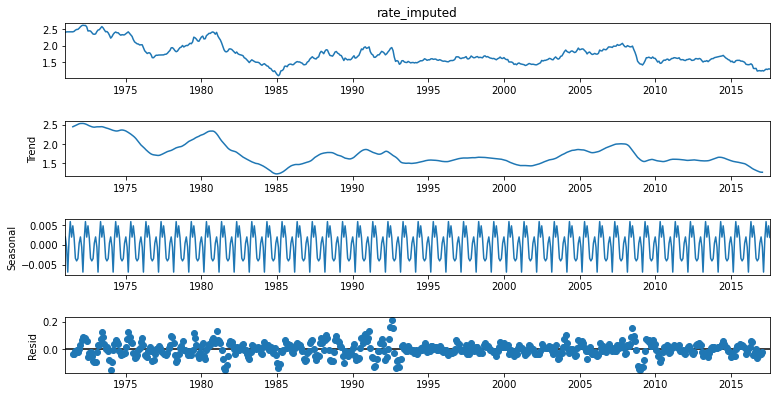

In [37]:
fig = decomposition.plot()
fig.set_size_inches(12, 6)
plt.show()

In [38]:
# model the residuals
resid = decomposition.resid

In [39]:
# remove missing
resid.dropna(inplace=True)
resid.isnull().sum()

0

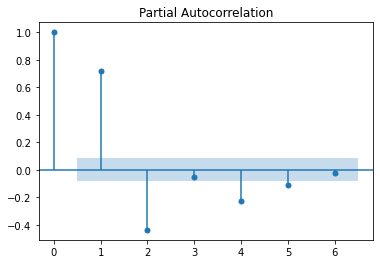

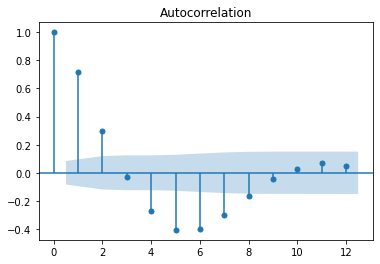

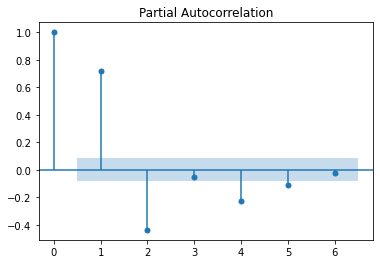

In [40]:
plot_acf(resid, lags=12)
plot_pacf(resid, lags=6)

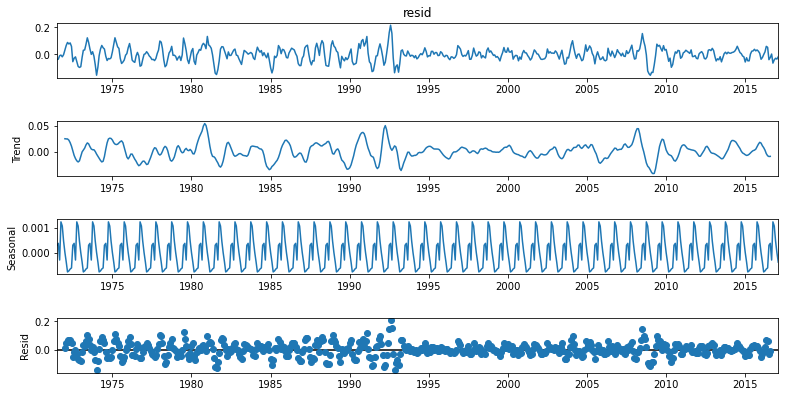

In [41]:

decomposition = seasonal_decompose(resid, period=12)
fig = decomposition.plot()
fig.set_size_inches(12, 6)
plt.show()

A few things to note here:

- The trend we've seen on previous plots, goes down in the first 10-15 years then it's more stable
- There appears to perhaps be some seasonality, which may be worth digging into
- The residual (error) terms are fairly uniform between 1993 and 2007 or so, but there are periods when they vary more. One instance is the financial crisis around 2008, where clearly the exchange rates were harder to predict!